In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import scipy.stats as stats
import pickle
import importlib
from scipy import stats
pd.options.mode.chained_assignment = None

In [3]:
file_names = ['..\\PhD_data\\rGT-variants\\CH01\\CH01_raw_S39-42.xlsx',
              '..\\PhD_data\\rGT-variants\\CH02\\CH02_raw_baseline_S43-46.xlsx',
              '..\\PhD_data\\rGT-variants\\NA01\\NA01_raw-baseline_S37-41.xlsx']


In [145]:
def load_multiple_data(fnames, reset_sessions=False): 
#load multiple datasets from computer and redo subject numbers
    for i,file in enumerate(fnames):
        if i == 0:
            df = pd.read_excel(fnames[i])
            df['Subject'] += 100
            if reset_sessions:
                for i,session in enumerate(df.Session.unique()):
                    for j in range(len(df)):
                        if df.at[j,'Session'] == session:
                            df.at[j,'Session'] = i + 1
        else:
            df2 = pd.read_excel(fnames[i])
            df2['Subject'] += 100 * (1+i)
            if reset_sessions:
                for i,session in enumerate(df2.Session.unique()):
                    for j in range(len(df2)):
                        if df2.at[j,'Session'] == session:
                            df2.at[j,'Session'] = i + 1
            df = df.append(df2, ignore_index = True)
    return df

def check_sessions(df):
    pd.set_option('display.max_rows', None)
    print(df.groupby(['Subject','StartDate','Session'])['Trial'].max())
    pd.set_option('display.max_rows',df.Subject.max())
    
def get_choices(df):
    #set up option column with correct P1 to P4 configuration for version A and B
    configA = np.array([1, 4, 0, 2, 3])
    configB = np.array([4, 1, 0, 3, 2])

    df['option'] = df['MSN'].str.contains("B").values*configB[df['Chosen'].astype('int').ravel()-1].astype('int') + \
        df['MSN'].str.contains("A").values*configA[df['Chosen'].astype('int').ravel()-1].astype('int')

    #fix zeros
    for i in range(len(df)):
        if df['Chosen'][i] == 0:
            df['option'][i] = 0
    return df
    
def get_session_percentage_rat(sess, df):
    df1 = df.loc[df['Session'] == sess]
    subs = df1.Subject.unique()
    subs.sort()
    percentage = pd.DataFrame(columns=[str(sess) + 'P1',str(sess) + 'P2',str(sess) + 'P3',str(sess) + 'P4'])
    for sub in subs:
        for i,column in enumerate(percentage.columns):
            percentage.at[sub,column] = (len(df1.loc[(df1.option == i + 1) & 
                                            (df1.Subject == sub)]))/(len(df1.loc[(df1['option'] != 0) & 
                                                                                (df.Subject == sub)])) *100
    return percentage

def get_allsession_choice_rat(df):
    df_sess = []
    for i in range(1,max(df.Session)+1):
        df_sess.append(get_session_percentage_rat(i,df))
    df1 = pd.concat(df_sess, axis=1)
    for i in range(1,max(df.Session)+1):
        df1['risk'+ str(i)] = df1[str(i)+'P1'] + df1[str(i)+'P2']- df1[str(i)+'P3'] - df1[str(i)+'P4']
    return df1

def get_premature(df,df1):
    #extract premature response information
    prem_resp = df.groupby(['Subject','Session'],as_index=False)['Premature_Resp'].sum()

    prem_resp['Trials'] = df.groupby(['Subject','Session'],as_index=False)['Trial'].count()['Trial']

    prem_resp['prem_percent'] = prem_resp['Premature_Resp']/prem_resp['Trials'] * 100

    for i in range(1,max(df.Session)+1):
        df1['prem' + str(i)] = prem_resp.loc[prem_resp['Session']==i].set_index('Subject')['prem_percent']
    return df1

    
def get_latencies(df_raw,df_sum):
    #extract collect and choice lat information
    collect_lat = df_raw.groupby(['Subject','Session'],as_index=False)['Collect_Lat'].mean()
    choice_lat = df_raw.groupby(['Subject','Session'],as_index=False)['Choice_Lat'].mean()
    for i in range(1,max(df_raw.Session)+1):
        df_sum['collect_lat' + str(i)] = collect_lat.loc[collect_lat['Session']==i].set_index('Subject')['Collect_Lat']
    for i in range(1,max(df_raw.Session)+1):
        df_sum['choice_lat' + str(i)] = choice_lat.loc[choice_lat['Session']==i].set_index('Subject')['Choice_Lat']
    return df_sum


def get_omit(df_raw,df_sum):
    omit = df_raw.groupby(['Subject','Session'],as_index=False)['Omit'].sum()
    for i in range(1,max(df_raw.Session)+1):
        df_sum['omit' + str(i)] = omit.loc[omit['Session']==i].set_index('Subject')['Omit']
    return df_sum

def get_trials(df_raw,df_sum):
    trials = df_raw.groupby(['Subject','Session'],as_index=False)['Trial'].count()
    for i in range(1,max(df_raw.Session)+1):
        df_sum['trial' + str(i)] = trials.loc[trials['Session']==i].set_index('Subject')['Trial']
    return df_sum

def get_summary_data(df):
    df = get_choices(df)
    df1 = get_allsession_choice_rat(df)
    df1 = get_latencies(df,df1)
    df1 = get_omit(df,df1)
    df1 = get_trials(df,df1)
    df1 = get_premature(df,df1)
    return df1
    
def group_avg_scores(df,groups, group_names):
    dfs = []
    for group in groups:
        dfs.append(df.loc[group])
    avg_scores = pd.DataFrame(columns=list(df1.columns))
    avg_stderror = pd.DataFrame(columns=avg_scores.columns)
    for column in avg_scores.columns:
        for i in range(len(groups)):
            avg_scores.at[i,column] = dfs[i][column].mean()
            avg_stderror.at[i,column] = stats.sem(dfs[i][column])
            
    avg_scores.rename(index=group_names,inplace = True)
    avg_stderror.rename(index=group_names, inplace = True)
    return avg_scores, avg_stderror

def choice_bar_plot(startsess, endsess, scores, sem,cmap = 'default'):
    sess = list(range(startsess,endsess + 1))
    labels = ['P1','P2','P3','P4']
    df = pd.DataFrame()
    df1 = pd.DataFrame()
    if cmap == 'Paired':
        colors = [plt.cm.Paired(5),plt.cm.Paired(1),plt.cm.Paired(4),plt.cm.Paired(0)]
    if cmap == 'default':
        colors = [plt.cm.Set1(1),plt.cm.Set1(0)]
    for choice in labels:
        df[choice] = scores.loc[:, [col for col in avg_scores.columns if choice in col 
                                    and int(col[:col.index('P')]) in sess]].mean(axis = 1)
        df1[choice] = sem.loc[:, [col for col in avg_scores.columns if choice in col 
                                    and int(col[:col.index('P')]) in sess]].mean(axis = 1)
    ax = df.transpose().plot.bar(rot = 0, yerr = df1.transpose(), capsize = 8, figsize = (15,8), width = .8)
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    plt.rcParams.update({'font.size': 20})
    ax.set_ylabel('% Choice', fontweight = 'bold', fontsize = 20)
    ax.set_title('P1-P4 Choice', fontweight = 'bold', fontsize = 22, pad = 20)
    ax.set_ylim(bottom = 0)
    ax.spines['right'].set_linewidth(0)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    ax.legend()
    
def rgt_plot(variable,startsess,endsess,group_names,title,scores,sem,cmap = 'default', highlight = None, var_title = None):
    if var_title == None:
        var_title = variable
    plt.rcParams.update({'font.size': 18})
    fig,ax = plt.subplots(figsize = (20,8))
    ax.set_ylabel(var_title)
    ax.set_xlabel('Session')
    ax.set_xlim(startsess,endsess)
    ax.set_title(title + ': ' + var_title + '\n' + 'Baseline session ' + str(startsess) + '-' + str(endsess))
    ax.spines['right'].set_linewidth(0)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    x=np.arange(startsess,endsess+1)
    if cmap == 'Paired':
        colors = [plt.cm.Paired(5),plt.cm.Paired(1),plt.cm.Paired(4),plt.cm.Paired(0)]
    if cmap == 'default':
        colors = [plt.cm.Set1(1),plt.cm.Set1(0)]
   
    for i,group in enumerate(group_names.values()):
        y = scores.loc[group,variable+str(startsess):variable+str(endsess)]
        plt.errorbar(x, y,
                     yerr = sem.loc[group,variable+str(startsess):variable+str(endsess)], 
                     label=group,linewidth=5, capsize = 8)
    if highlight != None:
        plt.axvline(highlight, 0, 1, color = 'gray', lw = 1)
        ax.fill_between([highlight,endsess], ax.get_ylim()[0], ax.get_ylim()[1], facecolor='gray', alpha=0.2)
    ax.legend()
    
def rgt_bar_plot(variable,startsess,endsess,group_names,title,scores,sem, var_title = None):
    if var_title == None:
        var_title = variable
    plt.rcParams.update({'font.size': 20}) 
    plt.rcParams["figure.figsize"] = (15,8)
    
    bars = [0,0,0,0,0]
    err = [0,0,0,0,0]
    sess = [variable + str(s) for s in list(range(startsess,endsess+1))]
    for i,group in enumerate(scores.index):
        bars[i] = scores.loc[group, [col for col in scores.columns if col in sess]].mean()
        err[i] = sem.loc[group, [col for col in sem.columns if col in sess]].mean()
        plt.bar(i, bars[i], yerr = err[i], capsize = 8, width = .7, color = ['C'+str(i)], label = scores.index[i])
   
    ax = plt.gca()
    plt.xticks([])
    plt.xlabel('Task', labelpad = 20)
    ax.set_ylabel('% Premature')
    ax.set_ylim(0,50)
    ax.set_title(var_title,fontweight = 'bold', fontsize = 22, pad = 20)
    ax.spines['right'].set_linewidth(0)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.legend()
    
    
def export_to_excel(df,groups,groupname,filename):
#save specified number of sessions as excel file
    dfs = []
    for group in groups:
        dfs.append(df.loc[group])
    for i,df in enumerate(dfs):
        df[groupname] = i
    df_export = pd.concat(dfs)
    df_export.sort_index(inplace = True)
    df_export.to_excel(filename, index_label = 'Subject')

In [73]:
avg_scores.loc['Standard cued', [col for col in avg_scores.columns if col in sess]].mean()

26.835999683397727

In [5]:
df = load_multiple_data(file_names, reset_sessions = True)

In [13]:
#check_sessions(df)
        

In [7]:
#make the MSN for the random-cue task start with a lower case, so it doesn't mess up the A vs B version choice assignment

for i in range(len(df)):
    if df.at[i,'MSN'] == 'AnarchyrGT_B-losscue_v6':
        df.at[i,'MSN'] = 'anarchyrGT_B-losscue_v6'

df['MSN'].unique()

array(['rGT_ClassicA', 'rGT_ClassicB', 'MisrGT_A-cue', 'MisrGT_B-cue',
       'rGT_A-cue', 'rGT_B-cue', 'LossrGT_A-losscue_v1',
       'LossrGT_B-losscue_v1', 'anarchyrGT_B-losscue_v6',
       'AnarchyrGT_A-losscue_v6', 'RGT_ClassicB', 'RGT_ClassicA'],
      dtype=object)

In [8]:
df1 = get_summary_data(df)

In [9]:
#create 5 lists that contain the subject numbers that were run on each of the six tasks

task_list = df.groupby(['MSN'])['Subject'].unique()

cued = np.concatenate((task_list['rGT_A-cue'], task_list['rGT_B-cue']))

uncued = np.concatenate(task_list[[task for task in df.MSN.unique() if 'Classic' in task]])

reverse = np.concatenate(task_list[[task for task in df.MSN.unique() if 'Mis' in task]])

anarchy = np.concatenate(task_list[[task for task in df.MSN.unique() if 'narchy' in task]])

allcue = np.concatenate(task_list[[task for task in df.MSN.unique() if 'LossrGT' in task]])

In [36]:
groups = [uncued, cued, reverse,  allcue, anarchy]
group_names = {0:'Uncued',1:'Standard cued',2:'Reverse cued',3:'Outcome cued',4:'Random cued'}

avg_scores, avg_sem = group_avg_scores(df1,groups, group_names)

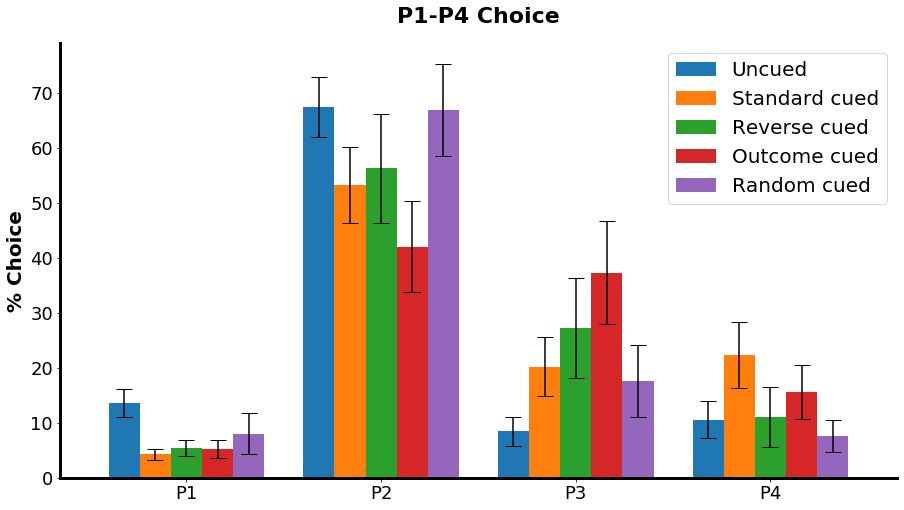

In [43]:
choice_bar_plot(1, 4, avg_scores, avg_sem)

#plt.savefig('..\\PhD_data\\rGT-variants\\rgt-variants_P1-P4_baseline',facecolor = 'white')

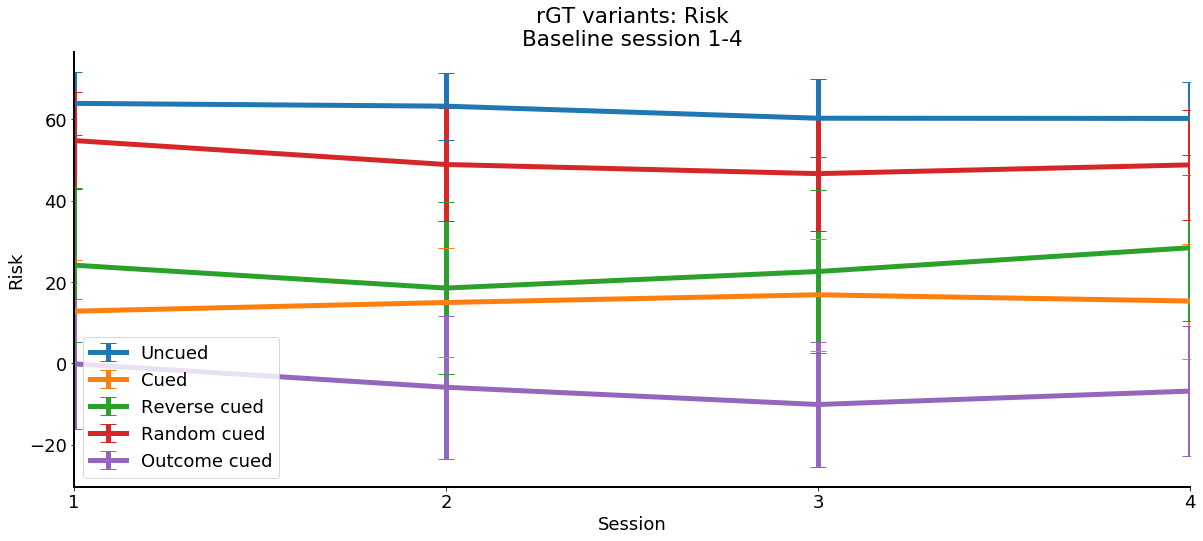

In [233]:
rgt_plot('risk',1,4,group_names,'rGT variants',avg_scores,avg_sem, var_title = 'Risk')

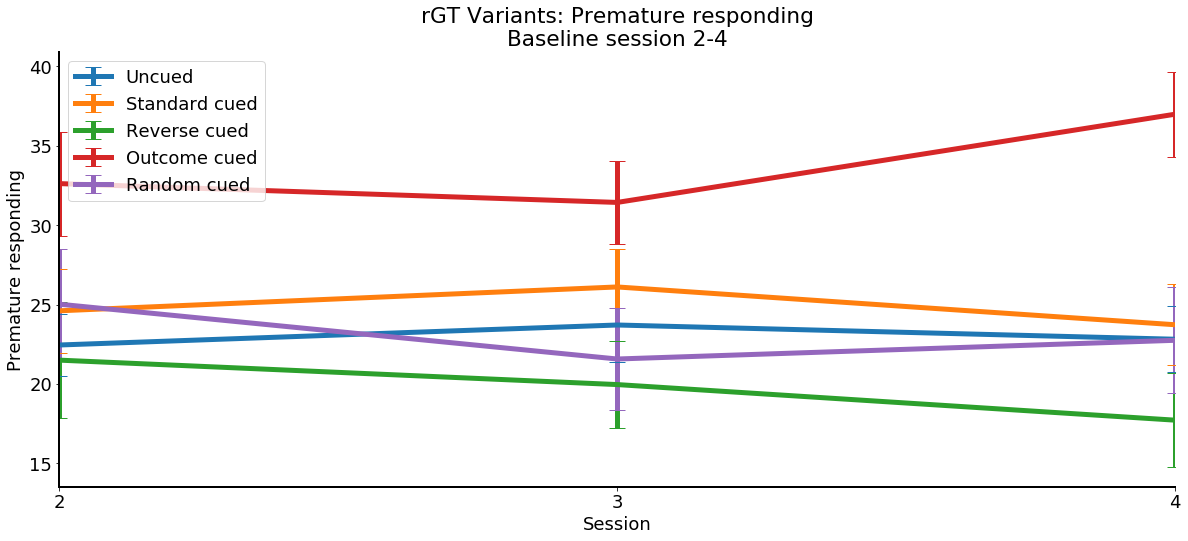

In [125]:
rgt_plot('prem',2,4,group_names,'rGT Variants',avg_scores,avg_sem, var_title = 'Premature responding')

#plt.savefig('..\\PhD_data\\rGT-variants\\rgt-variants_premature_baseline',facecolor = 'white')

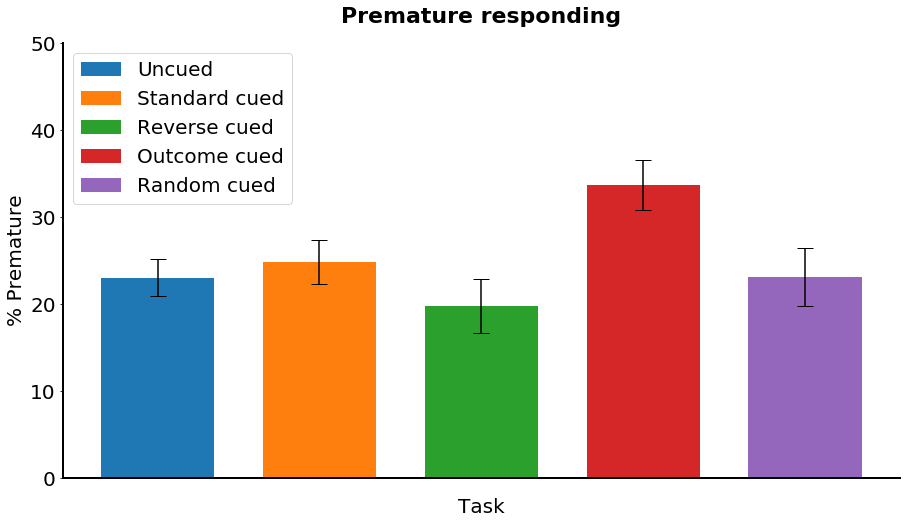

In [146]:
rgt_bar_plot('prem',2,4,group_names,'rGT Variants',avg_scores,avg_sem, var_title = 'Premature responding')

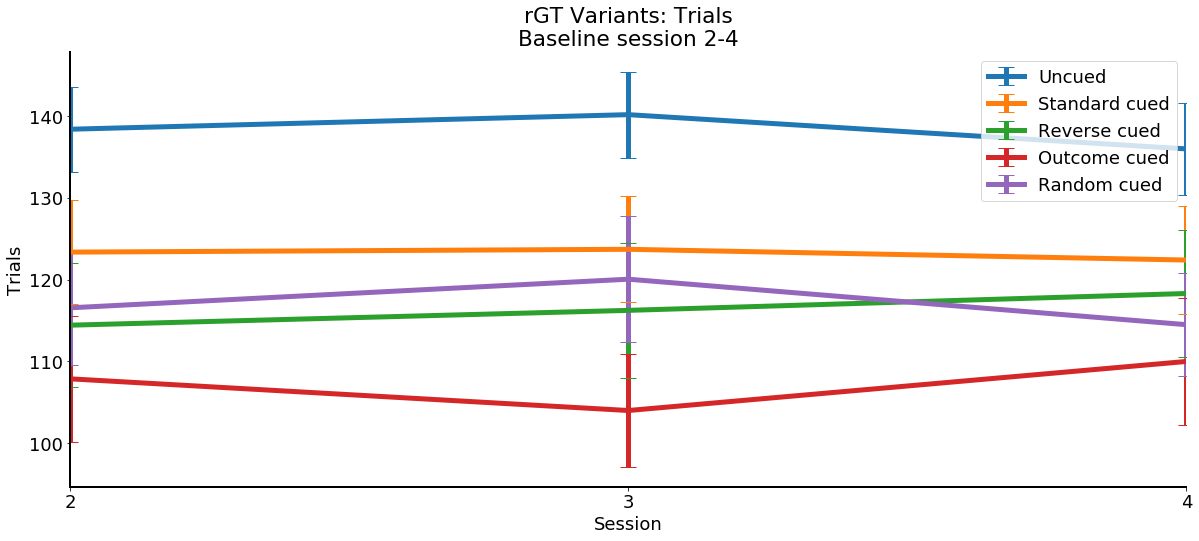

In [124]:
rgt_plot('trial',2,4,group_names,'rGT Variants',avg_scores,avg_sem, var_title = 'Trials')

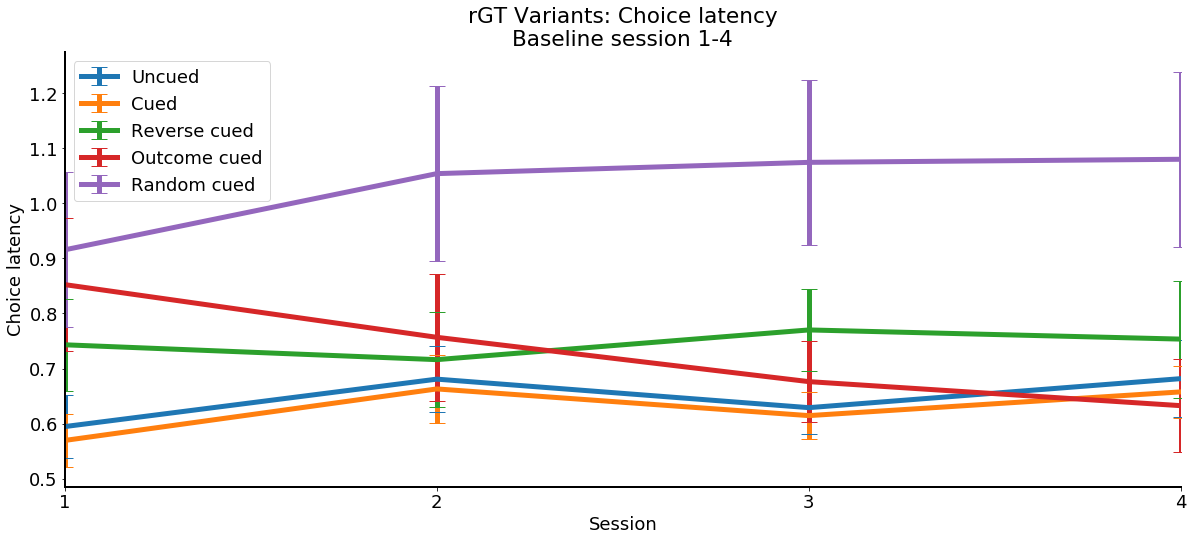

In [17]:
rgt_plot('choice_lat',1,4,group_names,'rGT Variants',avg_scores,avg_sem, var_title = 'Choice latency')

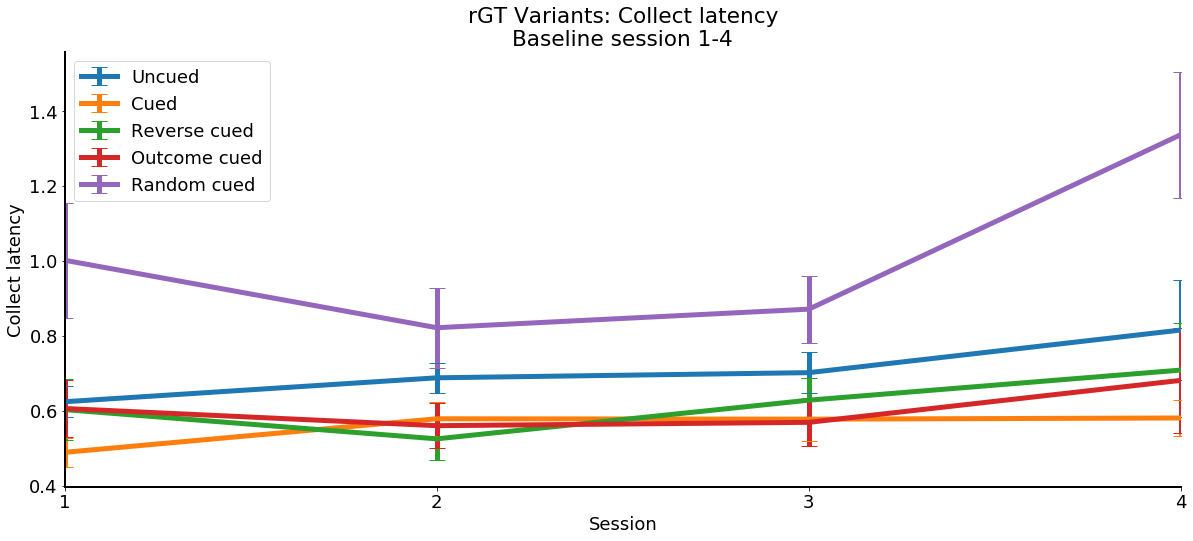

In [18]:
rgt_plot('collect_lat',1,4,group_names,'rGT Variants',avg_scores,avg_sem, var_title = 'Collect latency')

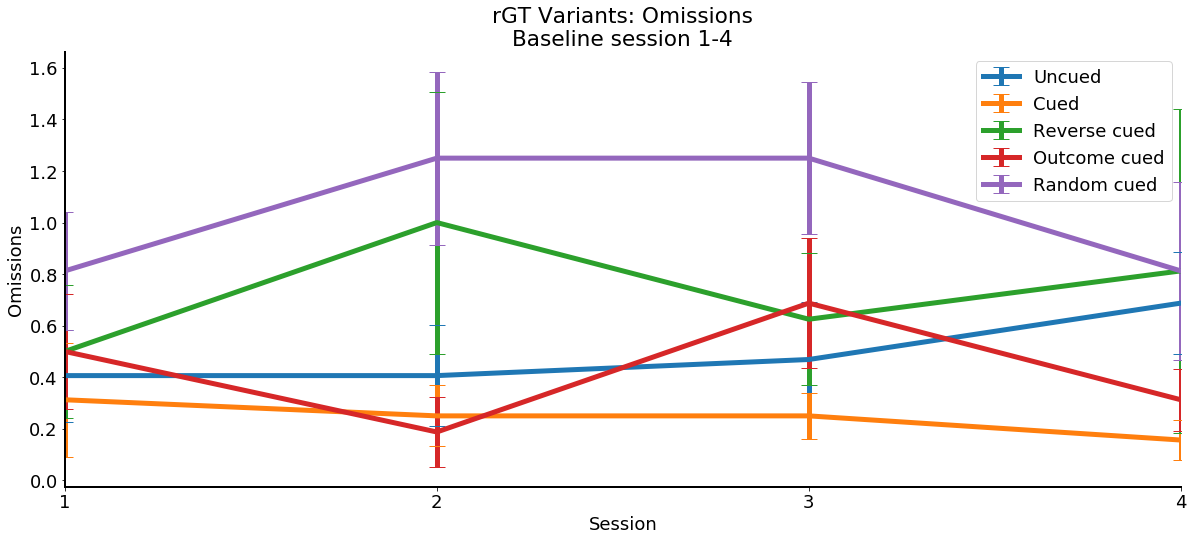

In [19]:
rgt_plot('omit',1,4,group_names,'rGT Variants',avg_scores,avg_sem, var_title = 'Omissions')

In [213]:
export_to_excel(df1,groups,'task','rgt-variants_baseline.xlsx')

In [253]:
df1.loc[anarchy]['collect_lat4']

301    1.402526
303    0.524035
305    1.525556
307    2.032526
317    1.937881
319    0.718889
321    1.893504
323    0.770744
302    1.353947
304    0.738190
306    0.564831
308    2.547925
318    1.134955
320    0.891462
322    0.860407
324    2.493380
Name: collect_lat4, dtype: float64